In [ ]:
# author: René Kopeinig
# script: Basic Proba-V NDVI Prediction
# description: Prediction on Proba-V NDVI (Normalized Difference Vegetation Index) Time-Series using Fourier Extrapolation and ARIMA with 
#              help of Google Earth Engine Python API.
#              Note: Please make sure you have all dependencies in Python installed and you are signed up for Google Earth Engine.

In [122]:
# Add IPython-specific directive to display plots directly below the notebook cell
%matplotlib inline

In [123]:
# Import Dependencies
import ee, datetime
import pandas as pd
import matplotlib.dates as mdates
from IPython.display import Image
from matplotlib import dates
from pylab import *
from numpy import fft
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [124]:
# Initialize
ee.Initialize()

# Set start and end date
startTime = datetime.datetime(2013, 2, 3)
endTime = datetime.datetime(2018, 4, 15)

# Create image collection
probav = ee.ImageCollection('VITO/PROBAV/C1/S1_TOC_100M').filterDate(startTime, endTime)
point = {'type':'Point', 'coordinates':[-89.70, 18.89]};

In [125]:
#Retrieve information over image collection
info = probav.getRegion(point,500).getInfo()

In [126]:
# Reshape Proba-V image collection 
header = info[0]
data = array(info[1:])
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

band_list=['NDVI']
iBands = [header.index(b) for b in band_list]
ndvi = data[0:,iBands].astype(np.float)

df = pd.DataFrame(data=ndvi, index=time, columns=['NDVI'])
time_series = df.dropna()

# Resampling
monthly = time_series.resample('M', how='mean')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  from ipykernel import kernelapp as app


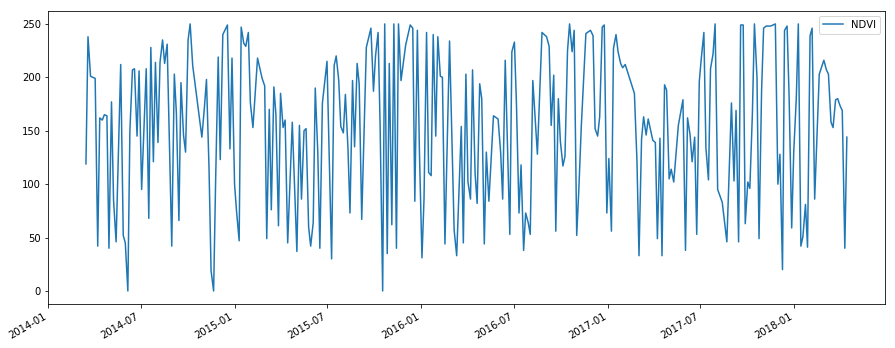

In [127]:
# Plot Proba-V NDVI Time Series
time_series.plot()

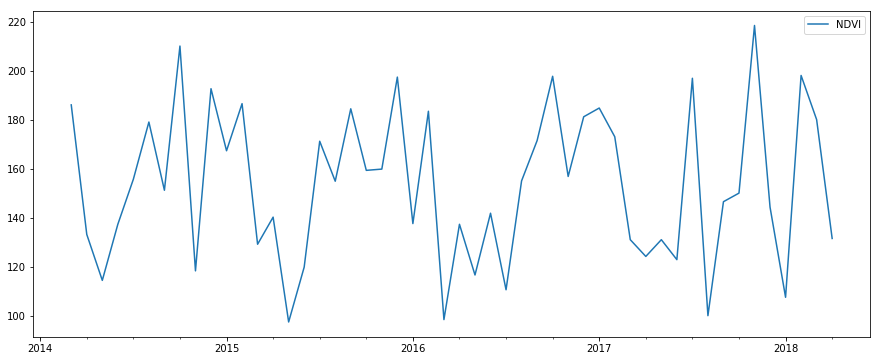

In [128]:
# Plot Monthly Proba-V NDVI Time Series
monthly.plot()

In [129]:
# Prediction using Fourier Extrapolation
def fourierExtrapolation(series, n_predict):
    t = np.arange(0, series.size)
    p = np.polyfit(t, series, 1)
    x_notrend = series - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(series.size)
    indexes = list(range(series.size))
    indexes.sort(key=lambda i: np.absolute(f[i]))
    t = np.arange(0, series.size  + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + 5 * 2]:
        ampli = np.absolute(x_freqdom[i]) / series.size
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    extrapolation = restored_sig + p[0] * t
    predicted = pd.DataFrame(data=extrapolation, columns=['predicted'])
    first = series.head(1).index[0]
    date_array = np.arange(first, len(series)+10, dtype='datetime64[M]')
    _index = pd.to_datetime(date_array)
    index = pd.to_datetime(_index, format="%Y%m") + MonthEnd(1)
    return predicted.set_index(index)

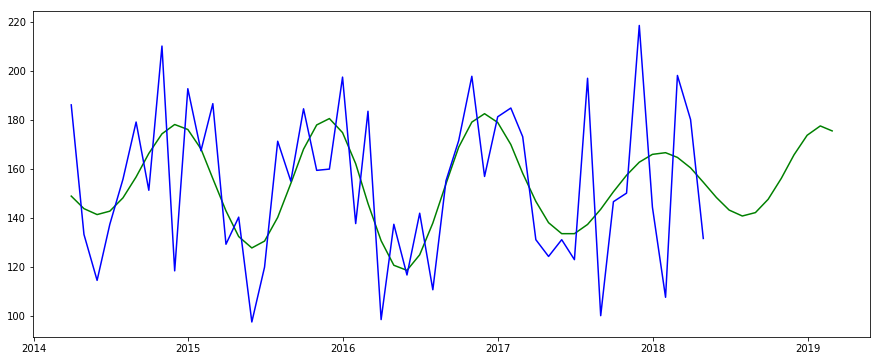

In [130]:
extrapolation=fourierExtrapolation(monthly['NDVI'], 10)
plot(extrapolation, color='green')
plot(monthly, color='blue')

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 2.3936')

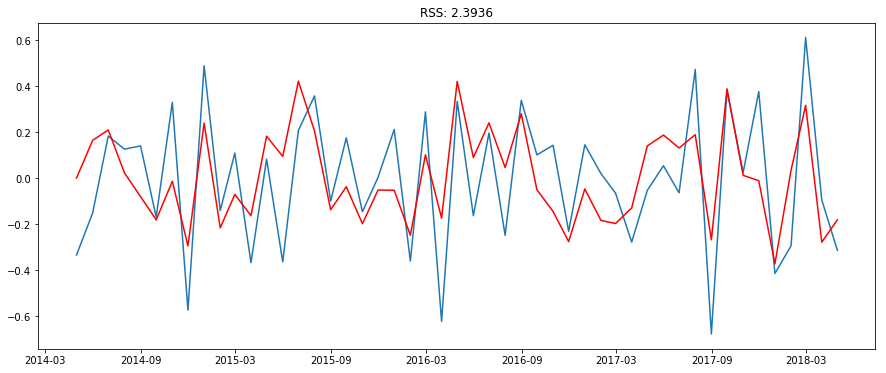

In [131]:
# Autoregressive Integrated Moving Average ARIMA Model
def arima_model(series):
    log_series = series.apply(lambda x: np.log(x))
    log_series_diff=log_series-log_series.shift()

    model=ARIMA(log_series, order=(1,1,1))
    results_ARIMA = model.fit(disp=-1)
    
    RSS = np.nansum((results_ARIMA.fittedvalues-log_series_diff)**2)
    return RSS, log_series_diff, results_ARIMA


RSS, log_series_diff, arima = arima_model(monthly['NDVI'])
plt.plot(log_series_diff)
plt.plot(arima.fittedvalues, color='red')
plt.title('RSS: %.4f'% RSS)